# Behavioral vs Neural Timescale Sweep 

Taking both the behavioral and neural timescales to be normally distributed, we run a sweep over different behavioral and neural timescale standard deviations.

## Set up

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [3]:
from pathlib import Path

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059"
)
os.path.exists(sweep_dir)

True

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters (from sweep config)
neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]


def load_experiment_data(sweep_dir, neural_std, behav_std, seed=0):
    """Load training losses and decoding errors for a single experiment."""
    exp_name = f"neural_std_{neural_std}_behav_std_{behav_std}"
    exp_path = sweep_dir / exp_name / f"seed_{seed}"

    # Load training losses
    with open(exp_path / "training_losses.json") as f:
        losses = json.load(f)

    # Load decoding errors
    with open(exp_path / "position_decoding_errors.json") as f:
        errors = json.load(f)

    return {
        "epochs": np.array(losses["epochs"]),
        "train_loss": np.array(losses["train_losses_epoch"]),
        "val_loss": np.array(losses["val_losses_epoch"]),
        "decoding_error": np.array(errors["position_errors_epoch"]),
    }


# Load all experiments
data = {}
for ns in neural_stds:
    for bs in behav_stds:
        data[(ns, bs)] = load_experiment_data(sweep_dir, ns, bs)


# === Plotting functions ===
def plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key,
    ylabel,
    title,
    log_x=False,
    log_y=False,
    figsize=(14, 12),
):
    """
    Create a 5x5 grid of plots.

    Rows: behavioral timescale std (increasing downward)
    Cols: neural timescale std (increasing rightward)
    """
    fig, axes = plt.subplots(5, 5, figsize=figsize, sharex=True, sharey=True)

    for i, bs in enumerate(behav_stds):
        for j, ns in enumerate(neural_stds):
            ax = axes[i, j]
            d = data[(ns, bs)]

            ax.plot(d["epochs"], d[metric_key], linewidth=1.5)

            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")

            # Title only on top row
            if i == 0:
                ax.set_title(f"τ_n std={ns}", fontsize=9)

            # Y-label only on left column
            if j == 0:
                ax.set_ylabel(f"τ_b std={bs}\n{ylabel}", fontsize=8)

            # X-label only on bottom row
            if i == len(behav_stds) - 1:
                ax.set_xlabel("Epoch", fontsize=8)

            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=7)

    fig.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()
    return fig, axes

ValueError: x and y must have same first dimension, but have shapes (100,) and (99,)

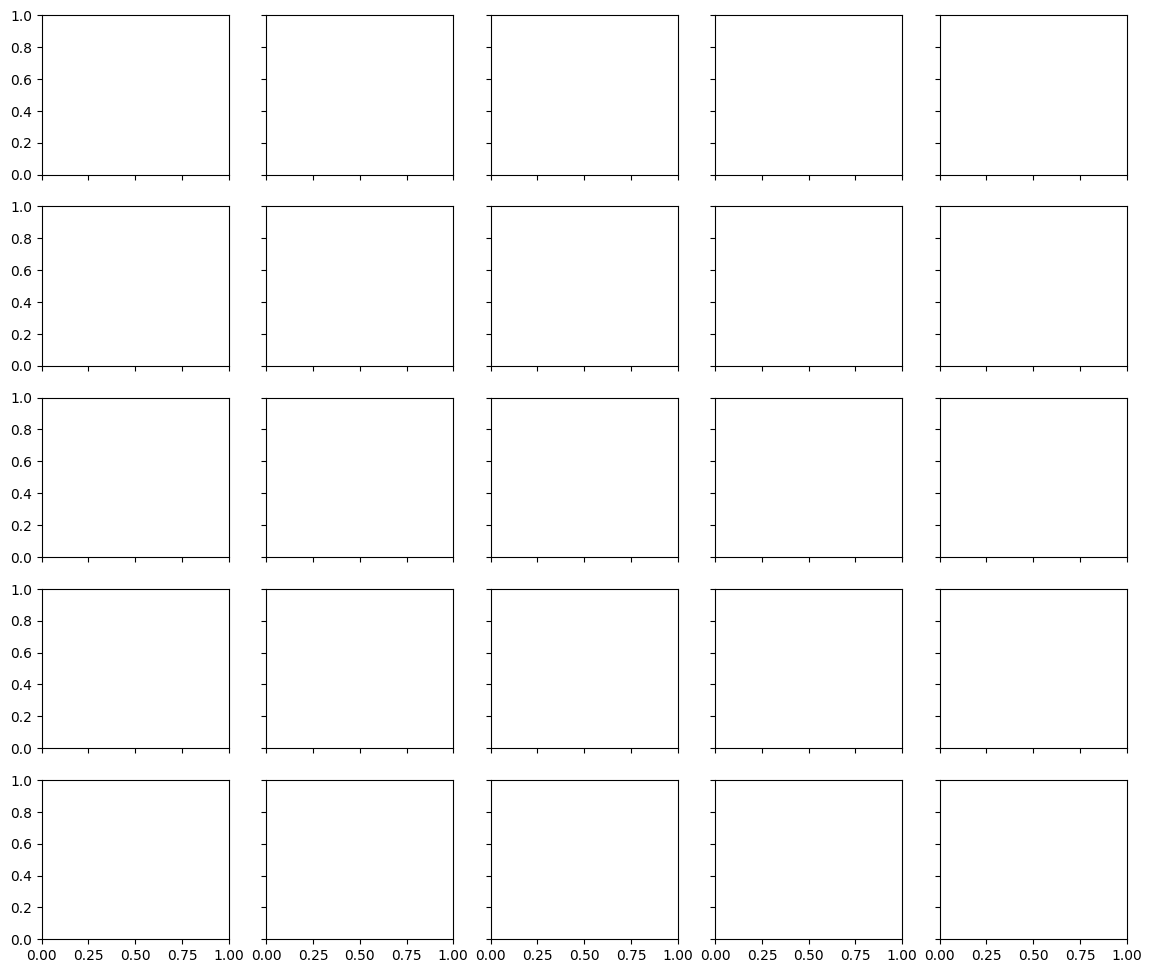

In [4]:
# 1. Training loss
fig1, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="train_loss",
    ylabel="Train Loss",
    title="Training Loss vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=False,
    log_y=False,
)
plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

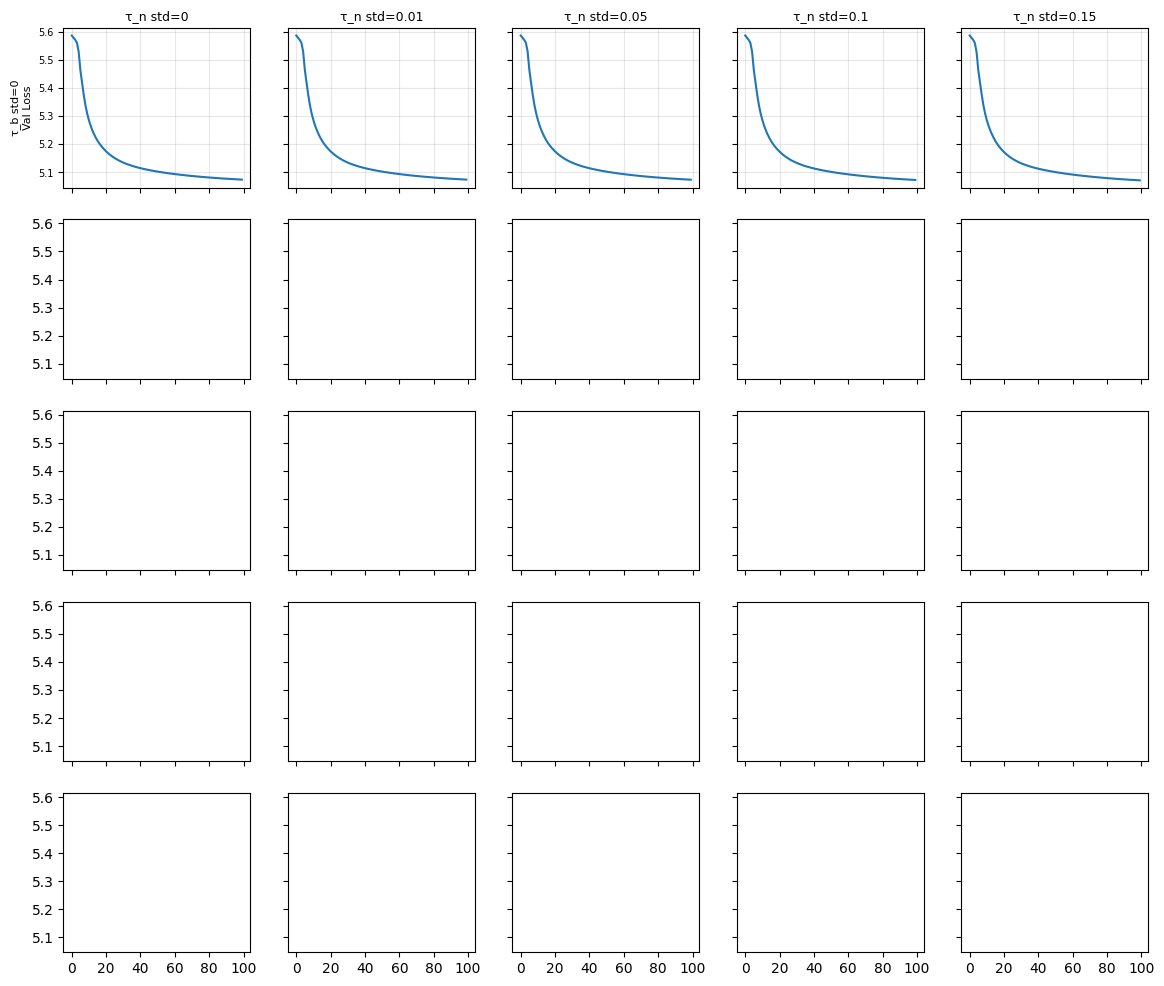

In [ ]:
# 2. Validation loss
fig2, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="val_loss",
    ylabel="Val Loss",
    title="Validation Loss vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=False,
    log_y=False,
)
plt.show()

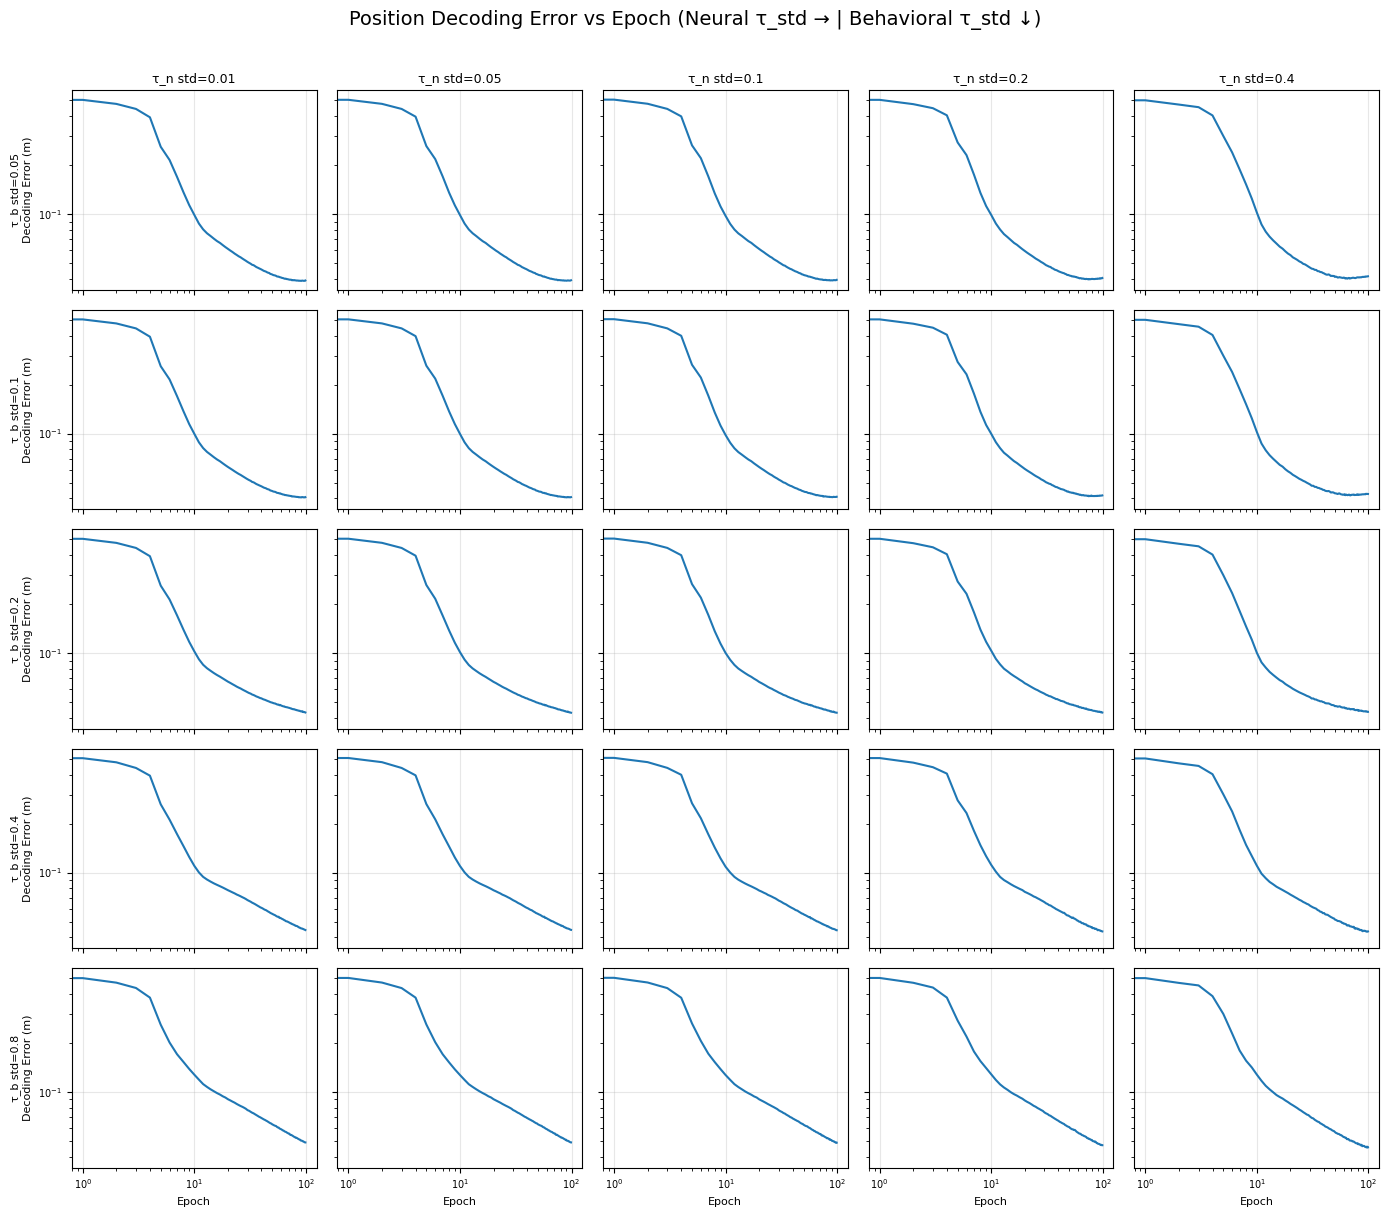

In [ ]:
# 3. Decoding error
fig3, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="decoding_error",
    ylabel="Decoding Error (m)",
    title="Position Decoding Error vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=True,
    log_y=True,
)
plt.show()

In [ ]:
import torch

def compute_target_entropy(exp_dir: Path, n_grid_points: int = 50):
    """Compute average target entropy over a grid of positions."""
    seed_dir = exp_dir / "seed_0"
    
    # Load place cell centers
    centers = torch.load(seed_dir / "place_cell_centers_seed0.pt")  # (N_pc, 2)
    
    # Load config for other params
    with open(seed_dir / "config_seed0.yaml") as f:
        cfg = yaml.safe_load(f)
    
    rf = cfg["place_cell_rf"]
    arena_size = cfg["arena_size"]
    DoG = cfg["DoG"]
    surround_scale = cfg["surround_scale"]
    
    # Create grid of positions spanning arena
    R = arena_size / 2
    xs = torch.linspace(-R, R, n_grid_points)
    ys = torch.linspace(-R, R, n_grid_points)
    xx, yy = torch.meshgrid(xs, ys, indexing='ij')
    positions = torch.stack([xx.flatten(), yy.flatten()], dim=-1)  # (N_pos, 2)
    
    # Compute place cell activations for each position
    # pos: (N_pos, 2), centers: (N_pc, 2)
    d2 = ((positions[:, None, :] - centers[None, :, :]) ** 2).sum(-1)  # (N_pos, N_pc)
    
    activations = torch.softmax(-d2 / (2 * rf**2), dim=-1)
    
    if DoG:
        surround = torch.softmax(-d2 / (2 * surround_scale * rf**2), dim=-1)
        activations = activations - surround
        activations = activations - activations.min(dim=-1, keepdim=True).values
        activations = activations / activations.sum(dim=-1, keepdim=True)
    
    # Compute entropy for each position, then average
    entropy = -(activations * torch.log(activations + 1e-8)).sum(-1)  # (N_pos,)
    
    return entropy.mean().item()

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Grid parameters
# neural_stds = [0, 0.01, 0.05, 0.1, 0.15 0.2, 0.4]
# behav_stds = [0.05, 0.1, 0.2, 0.4, 0.8]

neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]


def load_final_metrics(sweep_dir, neural_stds, behav_stds, seed=0, subtract_entropy=False):
    """Load final values for all experiments into 2D arrays.
    
    Args:
        sweep_dir: Path to sweep directory
        neural_stds: List of neural timescale std values
        behav_stds: List of behavioral timescale std values
        seed: Random seed (default 0)
        subtract_entropy: If True, subtract target entropy from losses to get KL divergence
    
    Returns:
        final_train_loss, final_val_loss, final_decoding_error (as KL if subtract_entropy=True)
    """
    n_neural = len(neural_stds)
    n_behav = len(behav_stds)

    final_train_loss = np.zeros((n_neural, n_behav))
    final_val_loss = np.zeros((n_neural, n_behav))
    final_decoding_error = np.zeros((n_neural, n_behav))
    target_entropies = np.zeros((n_neural, n_behav))  # For diagnostics

    for i, ns in enumerate(neural_stds):
        for j, bs in enumerate(behav_stds):
            exp_name = f"neural_std_{ns}_behav_std_{bs}"
            exp_path = sweep_dir / exp_name / f"seed_{seed}"

            with open(exp_path / "training_losses.json") as f:
                losses = json.load(f)
            with open(exp_path / "position_decoding_errors.json") as f:
                errors = json.load(f)

            train_loss = losses["train_losses_epoch"][-1]
            val_loss = losses["val_losses_epoch"][-1]
            
            if subtract_entropy:
                # Compute target entropy for this experiment
                H = compute_target_entropy(sweep_dir / exp_name)
                target_entropies[i, j] = H
                train_loss -= H
                val_loss -= H
            
            final_train_loss[i, j] = train_loss
            final_val_loss[i, j] = val_loss
            final_decoding_error[i, j] = errors["position_errors_epoch"][-1]

    if subtract_entropy:
        print(f"Target entropy range: {target_entropies.min():.4f} - {target_entropies.max():.4f}")
    
    return final_train_loss, final_val_loss, final_decoding_error


# Load all final metrics
final_train, final_val, final_error = load_final_metrics(
    sweep_dir, neural_stds, behav_stds, subtract_entropy=True
)


def plot_heatmap(
    matrix,
    neural_stds,
    behav_stds,
    title,
    cbar_label,
    cmap="viridis",
    figsize=(8, 6),
    annot=True,
    fmt=".3f",
):
    """
    Plot a heatmap with behavioral τ_std on x-axis and neural τ_std on y-axis.
    """
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(matrix, cmap=cmap, aspect="auto", origin="lower")

    # Set tick labels
    ax.set_xticks(np.arange(len(behav_stds)))
    ax.set_xticklabels([str(b) for b in behav_stds])
    ax.set_yticks(np.arange(len(neural_stds)))
    ax.set_yticklabels([str(n) for n in neural_stds])

    ax.set_xlabel("Behavioral Timescale Std (s)", fontsize=12)
    ax.set_ylabel("Neural Timescale Std (s)", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)

    # Annotate cells with values
    if annot:
        for i in range(len(neural_stds)):
            for j in range(len(behav_stds)):
                text = ax.text(
                    j,
                    i,
                    f"{matrix[i, j]:{fmt}}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white" if matrix[i, j] < matrix.mean() else "black",
                )

    plt.tight_layout()
    return fig, ax

Target entropy range: 5.0259 - 5.0259


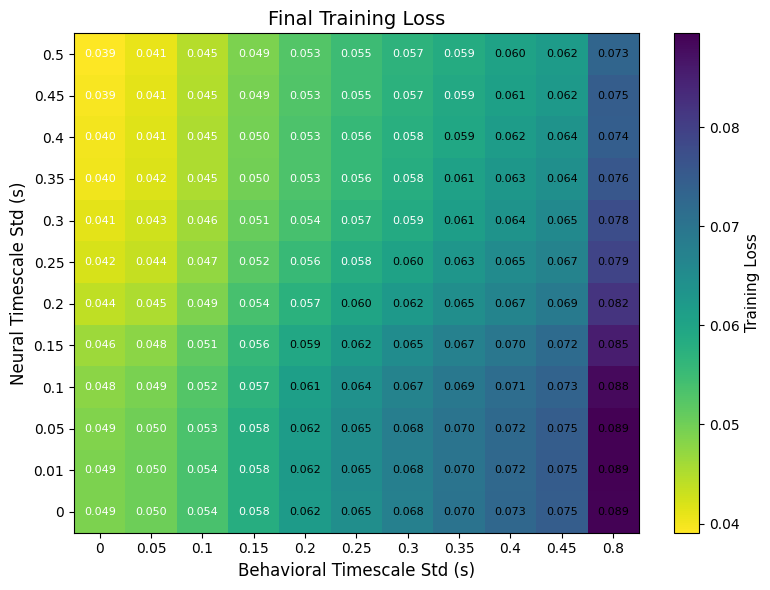

In [ ]:
# 1. Final Training Loss
fig1, _ = plot_heatmap(
    final_train,
    neural_stds,
    behav_stds,
    title="Final Training Loss",
    cbar_label="Training Loss",
    cmap="viridis_r",  # reversed so lower = better = darker
)
plt.show()

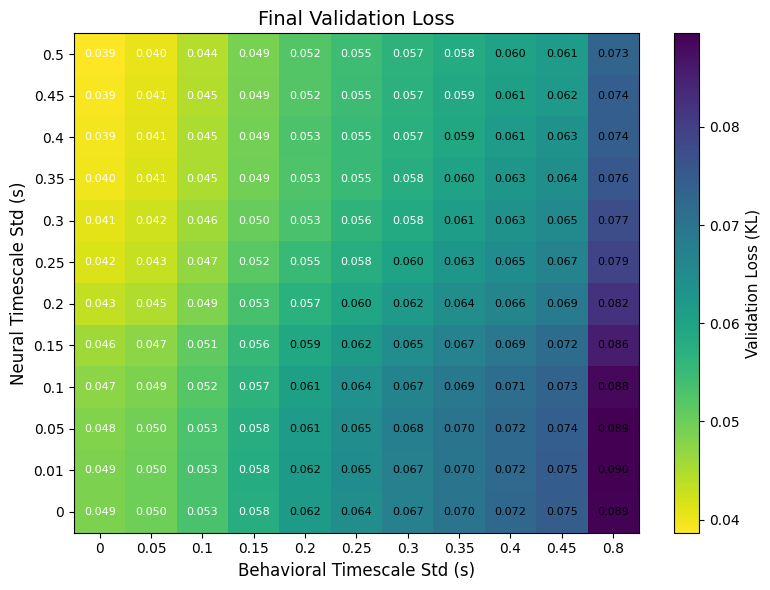

In [ ]:
# 2. Final Validation Loss
fig2, _ = plot_heatmap(
    final_val,
    neural_stds,
    behav_stds,
    title="Final Validation Loss",
    cbar_label="Validation Loss (KL)",
    cmap="viridis_r",
)
plt.show()

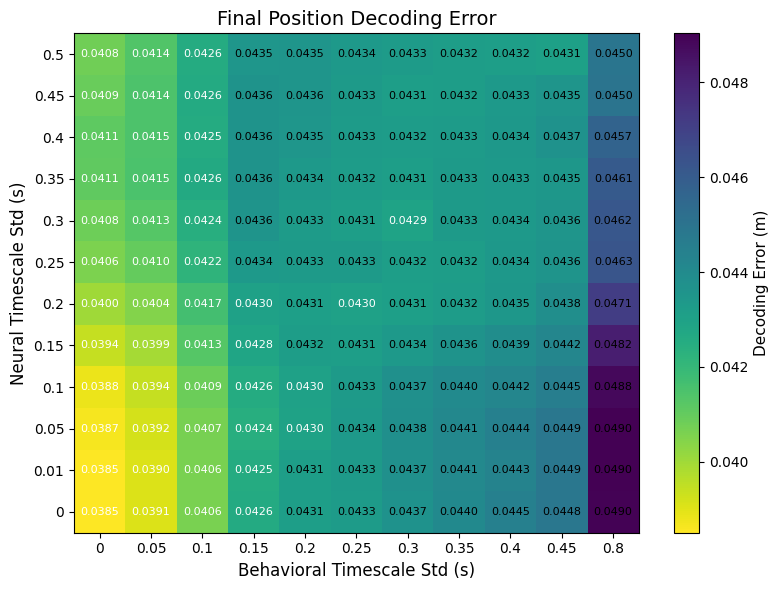

In [ ]:
# 3. Final Decoding Error
fig3, _ = plot_heatmap(
    final_error,
    neural_stds,
    behav_stds,
    title="Final Position Decoding Error",
    cbar_label="Decoding Error (m)",
    cmap="viridis_r",
    fmt=".4f",  # more precision for small errors
)
plt.show()

In [ ]:
# Subtract the target place cell distribution entropy
# H(P,Q) = H(P) + D_{KL}(P||Q)

# this gives us the KL divergence of the target distribution from the model distribution

## Look at neuron tuning curves

In [5]:
# Cell 1: Load models from the heterogeneity sweep
from timescales.analysis.load_models import load_experiment_sweep
import torch

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059"
)
device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

print(f"\nLoaded {len(models)} experiments")
print("Available experiments:", list(models.keys())[:5], "...")

Loading 132 experiments with 1 seeds each...
Total models to load: 132
Using Lightning checkpoints

Loading experiment: neural_std_0_behav_std_0
  ✓ Loaded neural_std_0_behav_std_0/seed_0
Loading experiment: neural_std_0_behav_std_0.05
  ✓ Loaded neural_std_0_behav_std_0.05/seed_0
Loading experiment: neural_std_0_behav_std_0.1
  ✓ Loaded neural_std_0_behav_std_0.1/seed_0
Loading experiment: neural_std_0_behav_std_0.15
  ✓ Loaded neural_std_0_behav_std_0.15/seed_0
Loading experiment: neural_std_0_behav_std_0.2
  ✓ Loaded neural_std_0_behav_std_0.2/seed_0
Loading experiment: neural_std_0_behav_std_0.25
  ✓ Loaded neural_std_0_behav_std_0.25/seed_0
Loading experiment: neural_std_0_behav_std_0.3
  ✓ Loaded neural_std_0_behav_std_0.3/seed_0
Loading experiment: neural_std_0_behav_std_0.35
  ✓ Loaded neural_std_0_behav_std_0.35/seed_0
Loading experiment: neural_std_0_behav_std_0.4
  ✓ Loaded neural_std_0_behav_std_0.4/seed_0
Loading experiment: neural_std_0_behav_std_0.45
  ✓ Loaded neural_st

In [ ]:
#Select a specific experiment and seed
exp_name = "neural_std_0.1_behav_std_0.1"  # <-- Change this to explore different models
seed = 0

model_data = models[exp_name][seed]
model = model_data["model"]
config = model_data["config"]
place_cell_centers = model_data["place_cell_centers"]

model.eval()
print(f"Selected: {exp_name}, seed {seed}")
print(f"  Neural τ std: {config['timescales_config']['std']}")
print(f"  Behavioral τ std: {config['behavioral_timescale_std']}")

Selected: neural_std_0.1_behav_std_0.1, seed 0
  Neural τ std: 0.1
  Behavioral τ std: 0.1


In [8]:
# Create evaluation datamodule matching this model's config
from timescales.datamodule import PathIntegrationDataModule

eval_datamodule = PathIntegrationDataModule(
    trajectory_type=config["trajectory_type"],
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],
    behavioral_timescale_mean=config["behavioral_timescale_mean"],
    behavioral_timescale_std=config["behavioral_timescale_std"],
    linear_speed_tau=config["linear_speed_tau"],
    angular_speed_mean=config["angular_speed_mean"],
    angular_speed_std=config["angular_speed_std"],
    angular_speed_tau=config["angular_speed_tau"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    DoG=config["DoG"],
    surround_scale=config["surround_scale"],
    place_cell_layout=config["place_cell_layout"],
    num_trajectories=10000,
    batch_size=1,
    num_workers=1,
    train_val_split=0.0,
)

# Override place cell centers to match training
eval_datamodule.place_cell_centers = place_cell_centers

eval_datamodule.setup()
eval_loader = eval_datamodule.val_dataloader()

print(f"Eval loader ready: {len(eval_loader)} batches")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.100s
  → linear_speed: mean=0.200m/s, std=0.020m/s
Eval loader ready: 10000 batches


In [11]:
# Compute and visualize spatial rate maps
from timescales.analysis.spatial import SpatialAnalyzer

spatial = SpatialAnalyzer(
    model=model,
    device=device,
    model_type="multitimescale",
)

spatial.compute_rate_maps(
    eval_loader=eval_loader,
    arena_size=config["arena_size"],
    bin_size=0.05,
    num_trajectories=4000,
    min_occupancy=10,
    time_lag=0,  # Change for prospective/retrospective analysis
)

Computing concurrent spatial rate maps using 4000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 1/4000 trajectories...
Processed 51/4000 trajectories...
Processed 101/4000 trajectories...
Processed 151/4000 trajectories...
Processed 201/4000 trajectories...
Processed 251/4000 trajectories...
Processed 301/4000 trajectories...
Processed 351/4000 trajectories...
Processed 401/4000 trajectories...
Processed 451/4000 trajectories...
Processed 501/4000 trajectories...
Processed 551/4000 trajectories...
Processed 601/4000 trajectories...
Processed 651/4000 trajectories...
Processed 701/4000 trajectories...
Processed 751/4000 trajectories...
Processed 801/4000 trajectories...
Processed 851/4000 trajectories...
Processed 901/4000 trajectories...
Processed 951/4000 trajectories...
Processed 1001/4000 trajectories...
Processed 1051/4000 trajectories...
Processed 1101/4000 trajectories...
Processed 1151/4000 trajectories...
Processed 1201/4000 traj

Selected 25 random units: [ 10  30  78  84 124 131 153 184 195 204 208 209 222 247 281 289 304 324
 325 352 361 439 495 497 506]


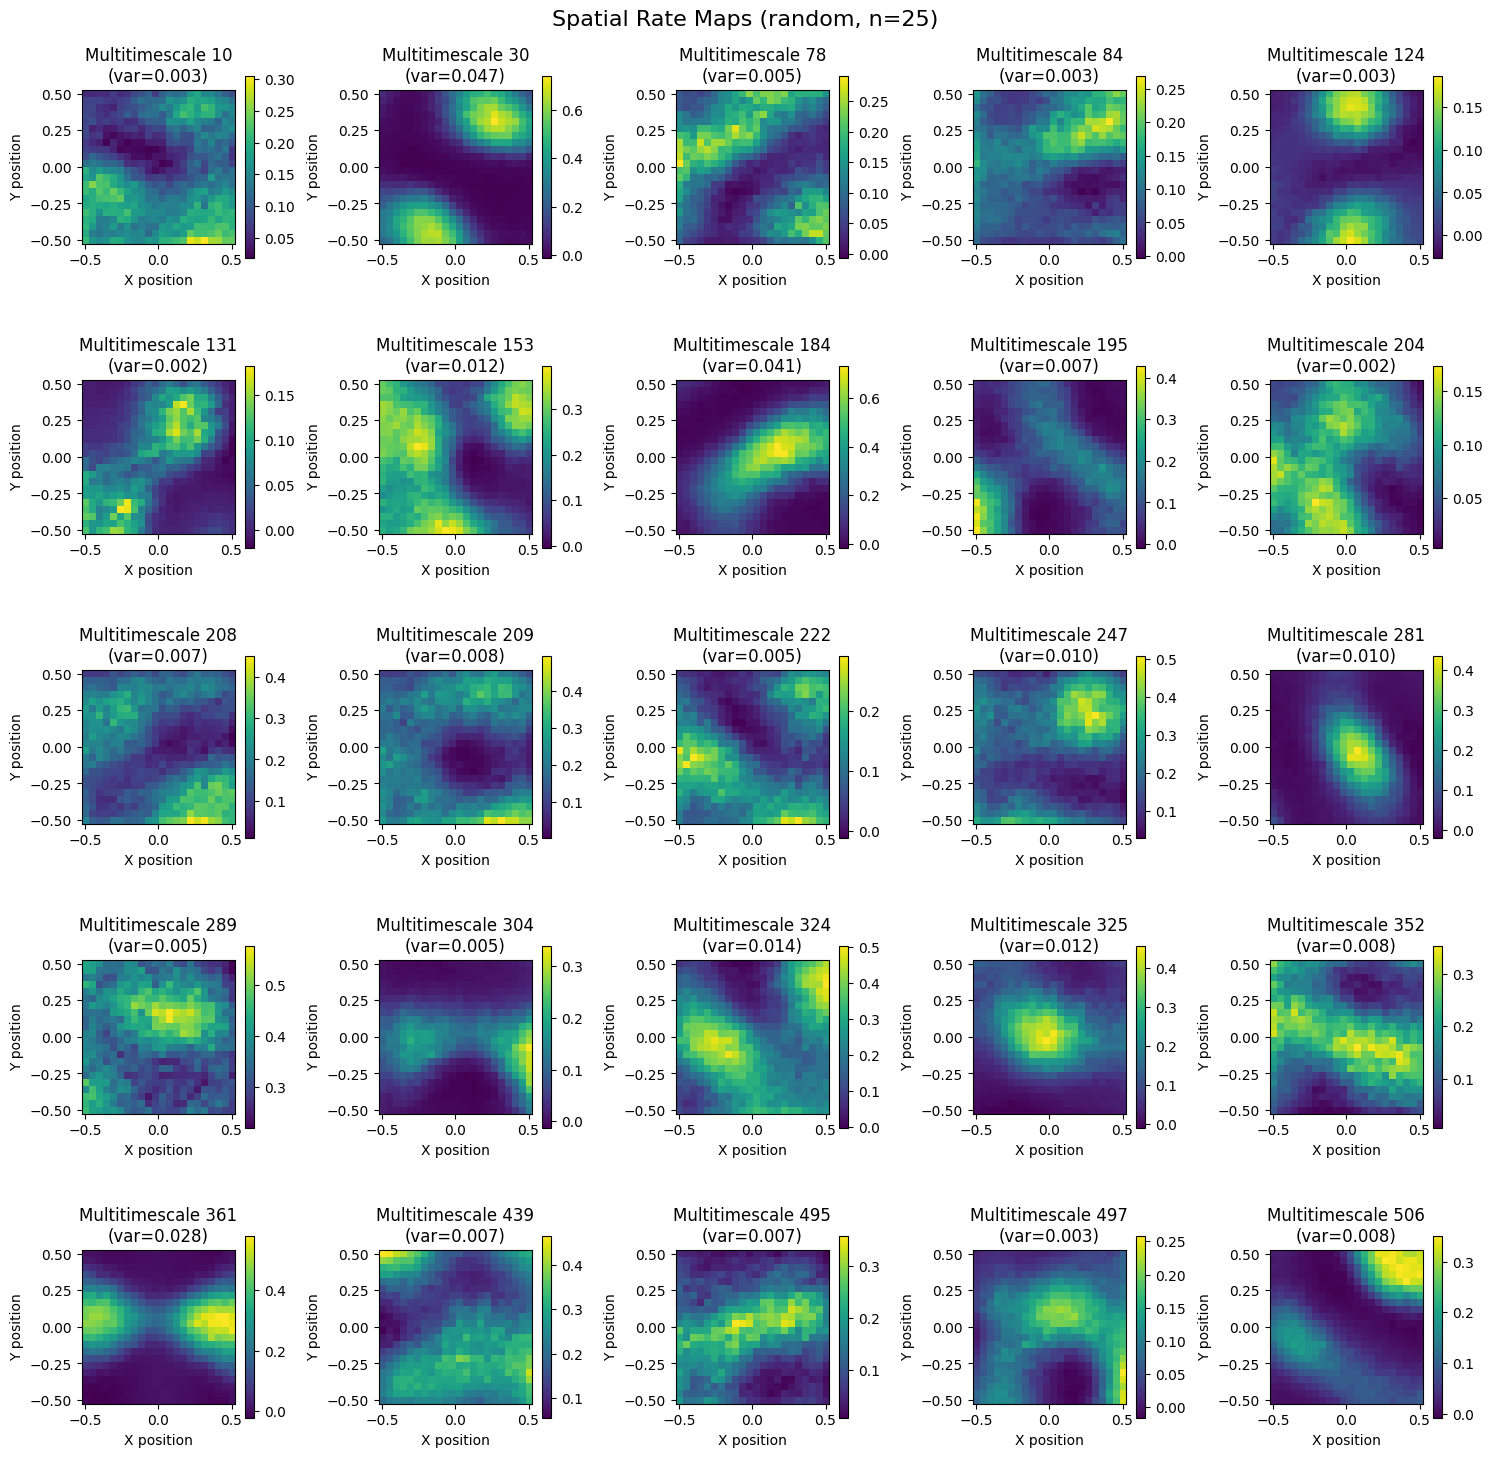

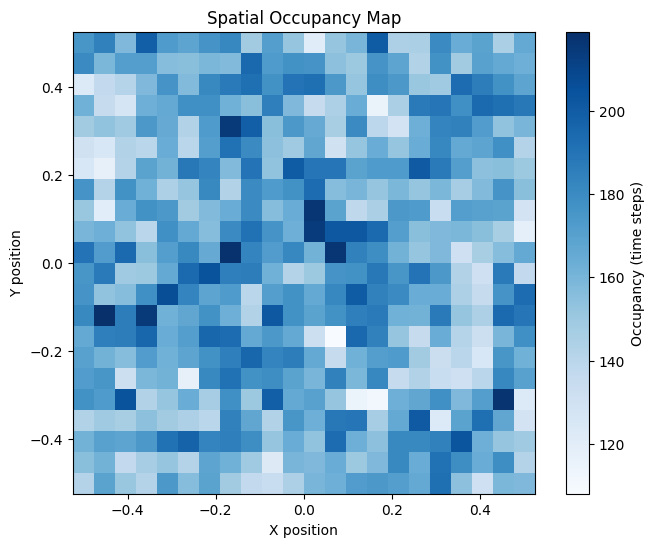


Visualized: neural_std_0.1_behav_std_0.1


In [12]:
# Plot top 25 units by spatial information
spatial.plot_rate_maps(num_units=25, selection_method="random").plot_occupancy_map()

print(f"\nVisualized: {exp_name}")

Computing grid scores for 512 units...


/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/512 units...
  Processed 100/512 units...
  Processed 150/512 units...
  Processed 200/512 units...
  Processed 250/512 units...
  Processed 300/512 units...
  Processed 350/512 units...
  Processed 400/512 units...
  Processed 450/512 units...
  Processed 500/512 units...
Grid score computation complete!
  Mean 60° score: 0.175 ± 0.440
  Mean 90° score: 0.385 ± 0.553
  Max 60° score: 1.567
  Max 90° score: 1.631


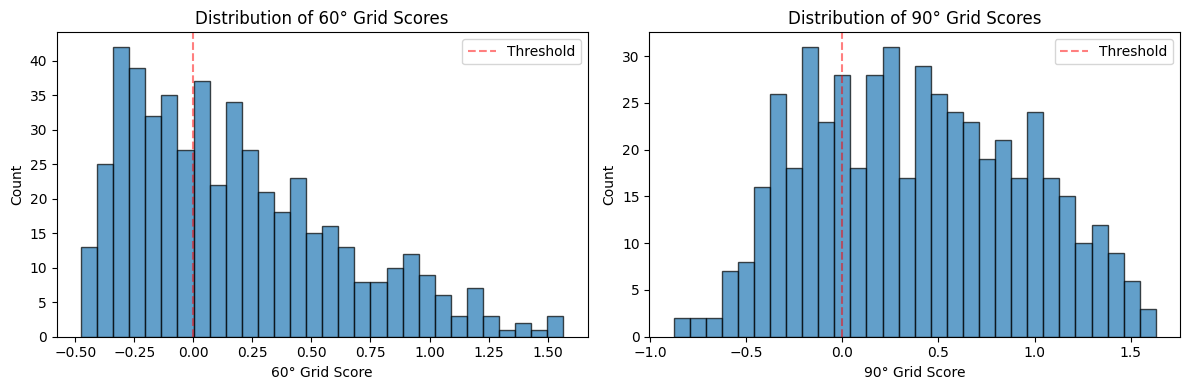

Units with positive 60° grid score: 300
Units with positive 90° grid score: 362


In [13]:
# Compute grid scores
grid_results = spatial.compute_grid_scores(
    mask_parameters=[(0.4, 1.0), (0.5, 1.0), (0.6, 1.0)],  # Try different scales
    min_max=False,
)

# Show distribution of grid scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(grid_results["scores_60"], bins=30, alpha=0.7, edgecolor="black")
axes[0].set_xlabel("60° Grid Score")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of 60° Grid Scores")
axes[0].axvline(0, color="red", linestyle="--", alpha=0.5, label="Threshold")
axes[0].legend()

axes[1].hist(grid_results["scores_90"], bins=30, alpha=0.7, edgecolor="black")
axes[1].set_xlabel("90° Grid Score")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of 90° Grid Scores")
axes[1].axvline(0, color="red", linestyle="--", alpha=0.5, label="Threshold")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Units with positive 60° grid score: {np.sum(grid_results['scores_60'] > 0)}")
print(f"Units with positive 90° grid score: {np.sum(grid_results['scores_90'] > 0)}")

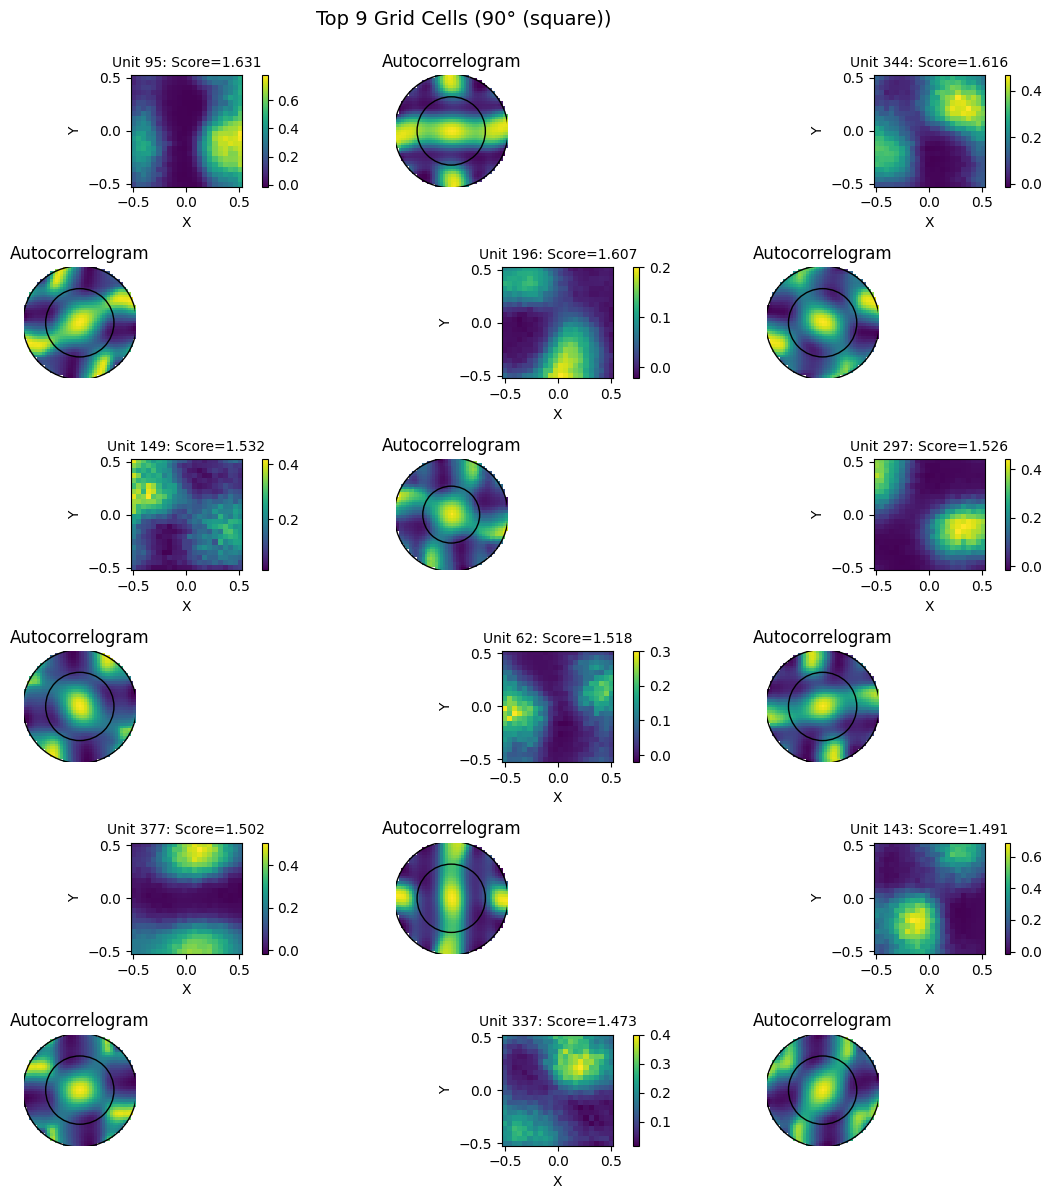

In [15]:
# Visualize top grid cells
spatial.plot_top_grid_cells(num_cells=9, score_type="90")

In [16]:
# Cell: Compute Grid Cell Percentages Across Sweep
import numpy as np
import matplotlib.pyplot as plt
from timescales.analysis.spatial import SpatialAnalyzer
from tqdm.auto import tqdm
import torch

# Parameters
grid_score_threshold = 0.0  # Common threshold: positive grid score
score_type = "60"  # Use 60-degree score for hexagonal grids (can also try '90')
num_trajectories = 2000
bin_size = 0.05

# Grid parameters (should match your sweep)
neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]

# Initialize results array
grid_cell_percentages = np.zeros((len(neural_stds), len(behav_stds)))
grid_cell_counts = np.zeros((len(neural_stds), len(behav_stds)))
total_units = np.zeros((len(neural_stds), len(behav_stds)))

# Loop through all experiments
print(
    f"Computing grid scores across {len(neural_stds)} x {len(behav_stds)} = {len(neural_stds)*len(behav_stds)} experiments"
)
print(f"Using threshold: {grid_score_threshold}, score type: {score_type}°")
print("-" * 80)

for i, ns in enumerate(neural_stds):
    for j, bs in enumerate(behav_stds):
        exp_name = f"neural_std_{ns}_behav_std_{bs}"

        # Check if experiment exists
        if exp_name not in models:
            print(f"Warning: {exp_name} not found in loaded models")
            continue

        # Get model for seed 0 (or loop over seeds if desired)
        seed = 0
        if seed not in models[exp_name]:
            print(f"Warning: seed {seed} not found for {exp_name}")
            continue

        model_data = models[exp_name][seed]
        model = model_data["model"]
        config = model_data["config"]

        print(
            f"[{i*len(behav_stds)+j+1}/{len(neural_stds)*len(behav_stds)}] Processing {exp_name}..."
        )

        try:
            # Initialize spatial analyzer
            spatial = SpatialAnalyzer(
                model=model,
                device=device,
                model_type="multitimescale",
            )

            # Compute rate maps
            spatial.compute_rate_maps(
                eval_loader=eval_loader,  # Make sure eval_loader is defined
                arena_size=config["arena_size"],
                bin_size=bin_size,
                num_trajectories=num_trajectories,
                min_occupancy=10,
                time_lag=0,
            )

            # Compute grid scores
            grid_results = spatial.compute_grid_scores(
                mask_parameters=[(0.4, 1.0), (0.5, 1.0), (0.6, 1.0)], min_max=False
            )

            # Get scores based on type
            if score_type == "60":
                scores = grid_results["scores_60"]
            else:
                scores = grid_results["scores_90"]

            # Count grid cells above threshold
            n_grid_cells = np.sum(scores > grid_score_threshold)
            n_total = len(scores)
            percentage = 100 * n_grid_cells / n_total

            # Store results
            grid_cell_percentages[i, j] = percentage
            grid_cell_counts[i, j] = n_grid_cells
            total_units[i, j] = n_total

            print(f"  → Grid cells: {n_grid_cells}/{n_total} ({percentage:.1f}%)")
            print(
                f"  → Mean score: {np.mean(scores):.3f}, Max score: {np.max(scores):.3f}"
            )

        except Exception as e:
            print(f"  ERROR processing {exp_name}: {e}")
            grid_cell_percentages[i, j] = np.nan

        print()

print("=" * 80)
print("Grid score computation complete!")
print(f"Overall statistics:")
print(f"  Mean grid cell percentage: {np.nanmean(grid_cell_percentages):.1f}%")
print(
    f"  Min: {np.nanmin(grid_cell_percentages):.1f}%, Max: {np.nanmax(grid_cell_percentages):.1f}%"
)

/home/facosta/.cache/pypoetry/virtualenvs/pirnns-yK7ughNc-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing grid scores across 12 x 11 = 132 experiments
Using threshold: 0.0, score type: 60°
--------------------------------------------------------------------------------
[1/132] Processing neural_std_0_behav_std_0...
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 1/2000 trajectories...
Processed 51/2000 trajectories...
Processed 101/2000 trajectories...
Processed 151/2000 trajectories...
Processed 201/2000 trajectories...
Processed 251/2000 trajectories...
Processed 301/2000 trajectories...
Processed 351/2000 trajectories...
Processed 401/2000 trajectories...
Processed 451/2000 trajectories...
Processed 501/2000 trajectories...
Processed 551/2000 trajectories...
Processed 601/2000 trajectories...
Processed 651/2000 trajectories...
Processed 701/2000 trajectories...
Processed 751/2000 trajectories...
Processed 801/2000 trajectories...
Processed 851/2000 trajectories...
Processed 901/200

/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/512 units...
  Processed 100/512 units...
  Processed 150/512 units...
  Processed 200/512 units...
  Processed 250/512 units...
  Processed 300/512 units...
  Processed 350/512 units...
  Processed 400/512 units...
  Processed 450/512 units...
  Processed 500/512 units...
Grid score computation complete!
  Mean 60° score: 0.183 ± 0.435
  Mean 90° score: 0.365 ± 0.537
  Max 60° score: 1.478
  Max 90° score: 1.554
  → Grid cells: 303/512 (59.2%)
  → Mean score: 0.183, Max score: 1.478

[2/132] Processing neural_std_0_behav_std_0.05...
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 1/2000 trajectories...
Processed 51/2000 trajectories...
Processed 101/2000 trajectories...
Processed 151/2000 trajectories...
Processed 201/2000 trajectories...
Processed 251/2000 trajectories...
Processed 301/2000 trajectories...
Processed 351/2000 trajectories...
Processed 401/2000 trajectories..

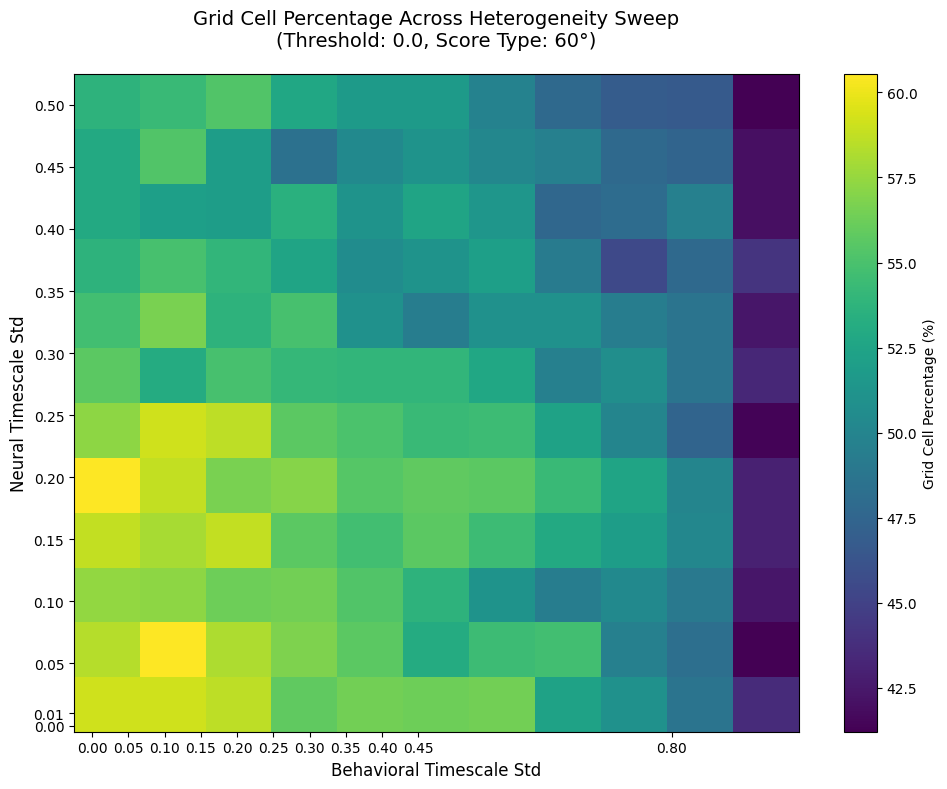

Key observations:
Experiment with highest grid cell %: neural_std=0.01, behav_std=0.05 (60.5%)
Experiment with lowest grid cell %: neural_std=0.01, behav_std=0.8 (41.2%)


In [20]:
# Cell: Visualize Grid Cell Percentage Heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create heatmap
im = ax.imshow(
    grid_cell_percentages,
    aspect="auto",
    cmap="viridis",  # or try 'RdYlGn', 'plasma', 'hot'
    origin="lower",
    extent=[
        behav_stds[0] - (behav_stds[1] - behav_stds[0]) / 2,
        behav_stds[-1] + (behav_stds[-1] - behav_stds[-2]) / 2,
        neural_stds[0] - (neural_stds[1] - neural_stds[0]) / 2,
        neural_stds[-1] + (neural_stds[-1] - neural_stds[-2]) / 2,
    ],
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label="Grid Cell Percentage (%)")

# Add grid cell percentage values as text
for i, ns in enumerate(neural_stds):
    for j, bs in enumerate(behav_stds):
        percentage = grid_cell_percentages[i, j]
        # if not np.isnan(percentage):
        # Choose text color based on background
        # text_color = "white" if percentage > 50 else "black"
        # ax.text(
        #     bs,
        #     ns,
        #     f"{percentage:.1f}",
        #     ha="center",
        #     va="center",
        #     color=text_color,
        #     fontsize=8,
        #     fontweight="bold",
        # )

# Labels and title
ax.set_xlabel("Behavioral Timescale Std", fontsize=12)
ax.set_ylabel("Neural Timescale Std", fontsize=12)
ax.set_title(
    f"Grid Cell Percentage Across Heterogeneity Sweep\n"
    f"(Threshold: {grid_score_threshold}, Score Type: {score_type}°)",
    fontsize=14,
    pad=20,
)

# Set tick positions
ax.set_xticks(behav_stds)
ax.set_yticks(neural_stds)

plt.tight_layout()
plt.show()

# Print some insights
print("Key observations:")
print(f"Experiment with highest grid cell %: ", end="")
max_idx = np.unravel_index(
    np.nanargmax(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[max_idx[0]]}, behav_std={behav_stds[max_idx[1]]} "
    f"({grid_cell_percentages[max_idx]:.1f}%)"
)

print(f"Experiment with lowest grid cell %: ", end="")
min_idx = np.unravel_index(
    np.nanargmin(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[min_idx[0]]}, behav_std={behav_stds[min_idx[1]]} "
    f"({grid_cell_percentages[min_idx]:.1f}%)"
)

In [21]:
# Cell: Save results for later analysis
import pickle

results_to_save = {
    "grid_cell_percentages": grid_cell_percentages,
    "grid_cell_counts": grid_cell_counts,
    "total_units": total_units,
    "neural_stds": neural_stds,
    "behav_stds": behav_stds,
    "threshold": grid_score_threshold,
    "score_type": score_type,
}

# Save to file
output_path = sweep_dir / f"grid_cell_analysis_threshold_{grid_score_threshold}.pkl"
with open(output_path, "wb") as f:
    pickle.dump(results_to_save, f)

print(f"Results saved to: {output_path}")

Results saved to: /home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059/grid_cell_analysis_threshold_0.0.pkl


## Load Saved Results and Re-Plot

Load the previously saved grid cell analysis results without re-running the expensive computation.


In [3]:
# Load saved results
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059"
)

# Choose which threshold file to load
grid_score_threshold = 0.0  # Change this to load different threshold results

load_path = sweep_dir / f"grid_cell_analysis_threshold_{grid_score_threshold}.pkl"
with open(load_path, "rb") as f:
    results = pickle.load(f)

# Unpack the results
grid_cell_percentages = results["grid_cell_percentages"]
grid_cell_counts = results["grid_cell_counts"]
total_units = results["total_units"]
neural_stds = results["neural_stds"]
behav_stds = results["behav_stds"]
grid_score_threshold = results["threshold"]
score_type = results["score_type"]

print(f"Loaded results from: {load_path}")
print(f"Grid shape: {grid_cell_percentages.shape}")
print(f"Neural stds: {neural_stds}")
print(f"Behav stds: {behav_stds}")
print(f"Threshold: {grid_score_threshold}, Score type: {score_type}")

Loaded results from: /home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059/grid_cell_analysis_threshold_0.0.pkl
Grid shape: (12, 11)
Neural stds: [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Behav stds: [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]
Threshold: 0.0, Score type: 60


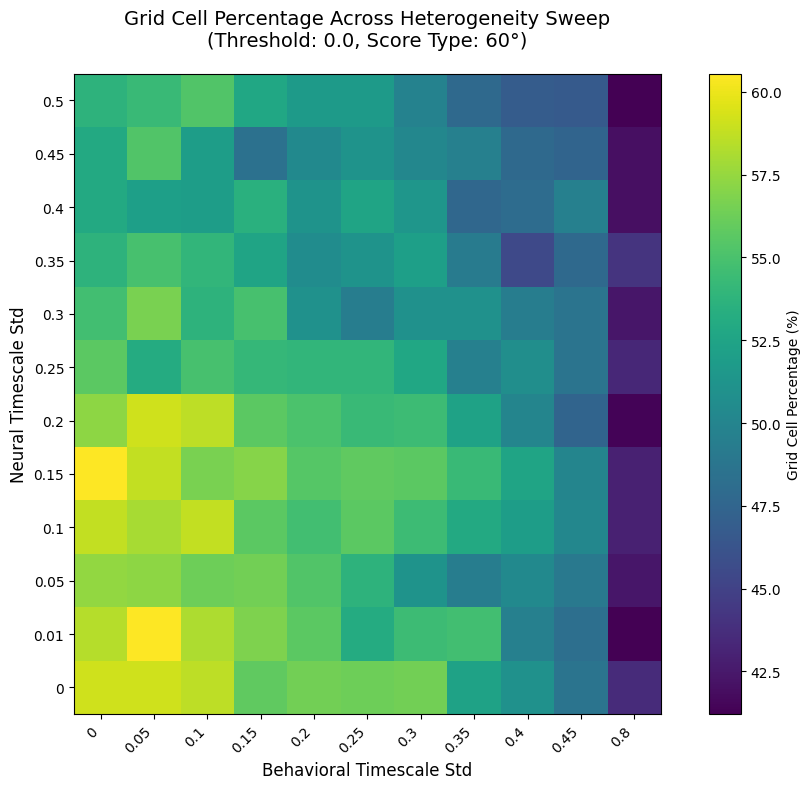


Key observations:
Experiment with highest grid cell %: neural_std=0.01, behav_std=0.05 (60.5%)
Experiment with lowest grid cell %: neural_std=0.01, behav_std=0.8 (41.2%)


In [7]:
# Visualize Grid Cell Percentage Heatmap (from loaded data)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Use index-based extent so cells are evenly spaced
n_neural = len(neural_stds)
n_behav = len(behav_stds)

# Create heatmap with index-based coordinates
im = ax.imshow(
    grid_cell_percentages,
    aspect=None,
    cmap="viridis",
    origin="lower",
    extent=[-0.5, n_behav - 0.5, -0.5, n_neural - 0.5],
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label="Grid Cell Percentage (%)")

# Labels and title
ax.set_xlabel("Behavioral Timescale Std", fontsize=12)
ax.set_ylabel("Neural Timescale Std", fontsize=12)
ax.set_title(
    f"Grid Cell Percentage Across Heterogeneity Sweep\n"
    f"(Threshold: {grid_score_threshold}, Score Type: {score_type}°)",
    fontsize=14,
    pad=20,
)

# Set tick positions at cell centers (integer indices) with actual values as labels
ax.set_xticks(range(n_behav))
ax.set_xticklabels([f"{v}" for v in behav_stds], rotation=45, ha="right")
ax.set_yticks(range(n_neural))
ax.set_yticklabels([f"{v}" for v in neural_stds])

plt.tight_layout()
plt.show()

# Print insights
print("\nKey observations:")
print(f"Experiment with highest grid cell %: ", end="")
max_idx = np.unravel_index(
    np.nanargmax(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[max_idx[0]]}, behav_std={behav_stds[max_idx[1]]} ({grid_cell_percentages[max_idx]:.1f}%)"
)

print(f"Experiment with lowest grid cell %: ", end="")
min_idx = np.unravel_index(
    np.nanargmin(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[min_idx[0]]}, behav_std={behav_stds[min_idx[1]]} ({grid_cell_percentages[min_idx]:.1f}%)"
)

## Analyze magntiude of latent activity through time

In [ ]:
import yaml
import torch
from rnns.multitimescale_rnn import MultiTimescaleRNN
from datamodule import PathIntegrationDataModule

# Pick an arbitrary experiment from the sweep
neural_std = 0.1
behav_std = 0.2
exp_name = f"neural_std_{neural_std}_behav_std_{behav_std}"
exp_dir = sweep_dir / exp_name / "seed_0"

print(f"Loading from: {exp_dir}")

# Load config
with open(exp_dir / "config_seed0.yaml") as f:
    config = yaml.safe_load(f)

# Load model
model_path = exp_dir / "final_model_seed0.pth"
model = MultiTimescaleRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    dt=config["dt"],
    timescales_config=config.get("timescales_config"),
    learn_timescales=config.get("learn_timescales", False),
)
model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
model.eval()

# Load place cell centers
place_cell_centers = torch.load(
    exp_dir / "place_cell_centers_seed0.pt", weights_only=True
)

print(f"Model loaded! Hidden size: {config['hidden_size']}")
print(f"Neural timescale config: {config.get('timescales_config')}")

Loading from: /home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059/neural_std_0.1_behav_std_0.2/seed_0
Model loaded! Hidden size: 512
Neural timescale config: {'distribution': 'gaussian', 'max_timescale': 2.0, 'mean': 0.5, 'min_timescale': 0.05, 'std': 0.1, 'type': 'continuous', 'values': [0.1443]}


In [5]:
# Create data module to generate trajectories
datamodule = PathIntegrationDataModule(
    trajectory_type=config["trajectory_type"],
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    DoG=config["DoG"],
    surround_scale=config["surround_scale"],
    place_cell_layout=config["place_cell_layout"],
    behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
    behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
    linear_speed_tau=config.get("linear_speed_tau", 1.0),
    angular_speed_mean=config.get("angular_speed_mean", 0.0),
    angular_speed_std=config.get("angular_speed_std", 1.0),
    angular_speed_tau=config.get("angular_speed_tau", 0.4),
    num_trajectories=100,
    batch_size=100,
    num_workers=10,
    train_val_split=0.0,
)
datamodule.place_cell_centers = place_cell_centers
datamodule.setup()

# Get a batch of trajectories
val_loader = datamodule.val_dataloader()
batch = next(iter(val_loader))
inputs, positions, place_cells = batch

print(f"Inputs shape: {inputs.shape}  (batch, time, input_size)")
print(f"Num time steps: {config['num_time_steps']}")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Inputs shape: torch.Size([100, 20, 2])  (batch, time, input_size)
Num time steps: 20


In [6]:
# Extract hidden state activations
with torch.no_grad():
    hidden_states, outputs = model(inputs, place_cells[:, 0, :])

print(f"Hidden states shape: {hidden_states.shape}  (batch, time, hidden_size)")

# Compute L2 norm (magnitude) of hidden state at each time step
# hidden_states: (batch, time, hidden_size)
hidden_norms = torch.norm(hidden_states, dim=2).numpy()  # (batch, time)

print(f"Hidden norms shape: {hidden_norms.shape}")
print(f"Mean norm across batch: {hidden_norms.mean(axis=0)}")

Hidden states shape: torch.Size([100, 20, 512])  (batch, time, hidden_size)
Hidden norms shape: (100, 20)
Mean norm across batch: [ 1.7371743  2.472367   3.269941   3.9860048  4.6570606  5.2470107
  5.8056946  6.352849   6.8319135  7.25943    7.654336   8.003397
  8.320322   8.612783   8.90637    9.174473   9.428499   9.683634
  9.937488  10.192807 ]


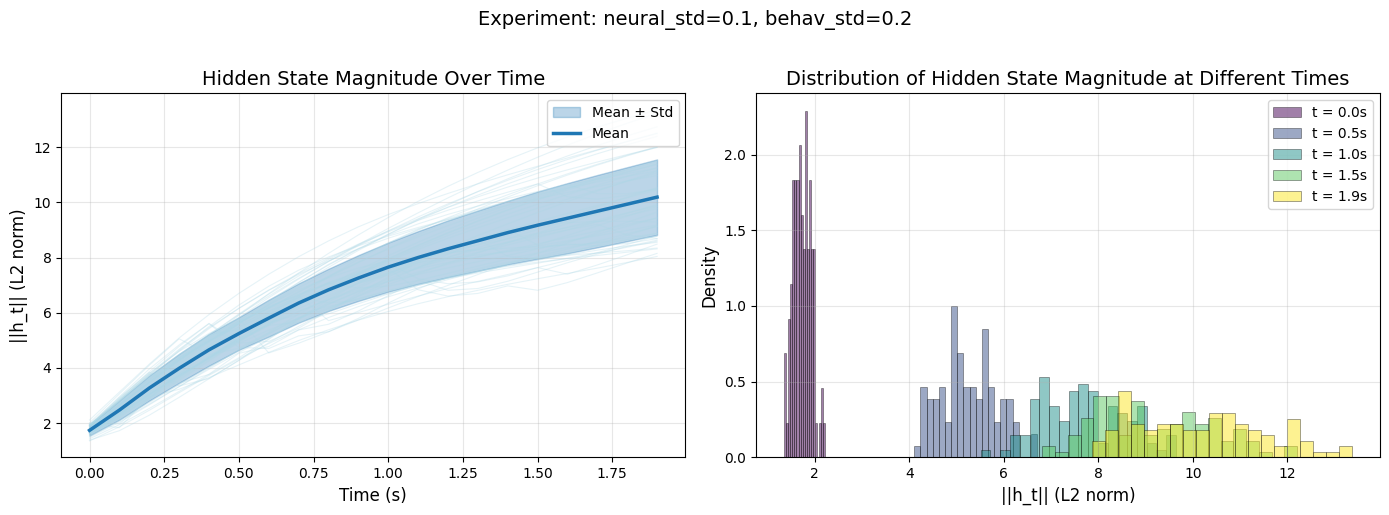


Summary:
  Initial magnitude: 1.7372 ± 0.1867
  Final magnitude:   10.1928 ± 1.3672
  Ratio (final/initial): 5.8675


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize hidden state magnitude over time
num_timesteps = hidden_states.shape[1]
time = np.arange(num_timesteps) * config["dt"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: All trajectories (faded) + mean
ax1 = axes[0]
for i in range(min(50, hidden_norms.shape[0])):  # Plot up to 50 trajectories
    ax1.plot(time, hidden_norms[i], color="lightblue", alpha=0.3, linewidth=0.8)

mean_norm = hidden_norms.mean(axis=0)
std_norm = hidden_norms.std(axis=0)
ax1.fill_between(
    time,
    mean_norm - std_norm,
    mean_norm + std_norm,
    alpha=0.3,
    color="tab:blue",
    label="Mean ± Std",
)
ax1.plot(time, mean_norm, color="tab:blue", linewidth=2.5, label="Mean")

ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax1.set_title("Hidden State Magnitude Over Time", fontsize=14)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Right plot: Distribution of norms at different time points
ax2 = axes[1]
time_indices = [
    0,
    num_timesteps // 4,
    num_timesteps // 2,
    3 * num_timesteps // 4,
    num_timesteps - 1,
]
colors = plt.cm.viridis(np.linspace(0, 1, len(time_indices)))

for idx, t_idx in enumerate(time_indices):
    ax2.hist(
        hidden_norms[:, t_idx],
        bins=20,
        alpha=0.5,
        color=colors[idx],
        label=f"t = {time[t_idx]:.1f}s",
        density=True,
        edgecolor="black",
        linewidth=0.5,
    )

ax2.set_xlabel("||h_t|| (L2 norm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Distribution of Hidden State Magnitude at Different Times", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

fig.suptitle(
    f"Experiment: neural_std={neural_std}, behav_std={behav_std}", fontsize=14, y=1.02
)
plt.tight_layout()
plt.show()

# Summary stats
print(f"\nSummary:")
print(f"  Initial magnitude: {mean_norm[0]:.4f} ± {std_norm[0]:.4f}")
print(f"  Final magnitude:   {mean_norm[-1]:.4f} ± {std_norm[-1]:.4f}")
print(f"  Ratio (final/initial): {mean_norm[-1] / mean_norm[0]:.4f}")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.050s
  → linear_speed: mean=0.200m/s, std=0.010m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.800s
  → linear_speed: mean=0.200m/s, std=0.160m/s


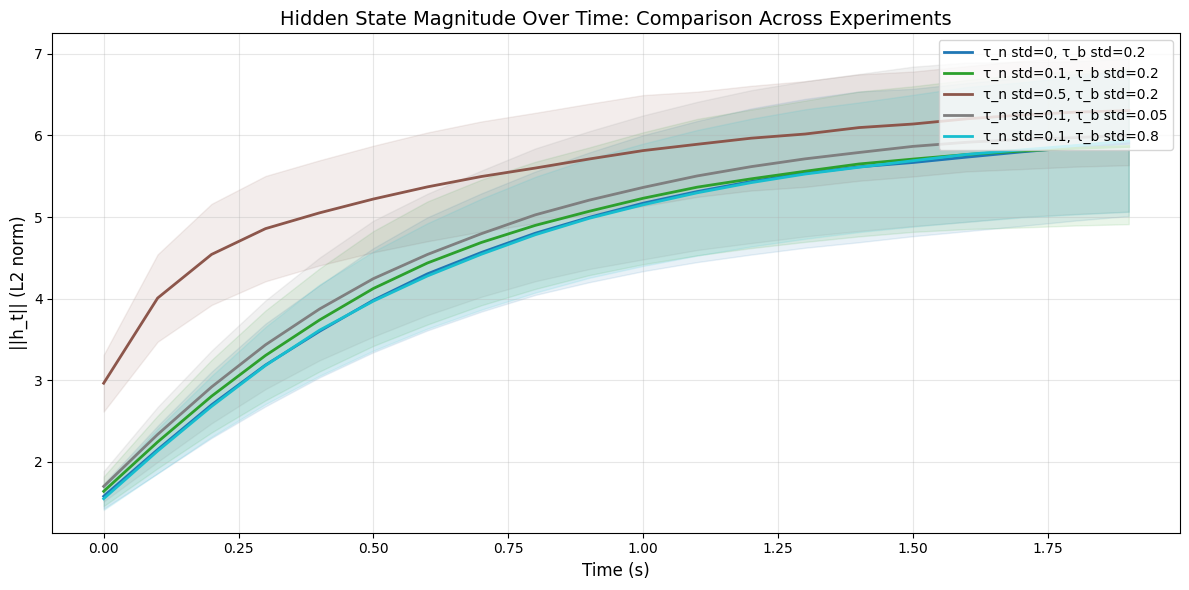

In [26]:
# Compare magnitude dynamics across a few different experiments
experiments_to_compare = [
    (0, 0.2),  # Low neural std
    (0.1, 0.2),  # Medium neural std
    (0.5, 0.2),  # High neural std
    (0.1, 0.05),  # Medium neural, low behav
    (0.1, 0.8),  # Medium neural, high behav
]


def compute_magnitude_dynamics(exp_dir, config):
    """Load model and compute magnitude dynamics."""
    # Load model with correct activation
    activation_fn = getattr(torch.nn, config["activation"])
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=config.get("timescales_config"),
        activation=activation_fn,  # Use activation from config
        learn_timescales=config.get("learn_timescales", False),
    )
    model.load_state_dict(
        torch.load(
            exp_dir / "final_model_seed0.pth", map_location="cpu", weights_only=True
        )
    )
    model.eval()

    # Load place cell centers
    pcc = torch.load(exp_dir / "place_cell_centers_seed0.pt", weights_only=True)

    # Generate trajectories
    dm = PathIntegrationDataModule(
        trajectory_type=config["trajectory_type"],
        velocity_representation=config["velocity_representation"],
        dt=config["dt"],
        num_time_steps=config["num_time_steps"],
        arena_size=config["arena_size"],
        num_place_cells=config["num_place_cells"],
        place_cell_rf=config["place_cell_rf"],
        DoG=config["DoG"],
        surround_scale=config["surround_scale"],
        place_cell_layout=config["place_cell_layout"],
        behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
        behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
        linear_speed_tau=config.get("linear_speed_tau", 1.0),
        angular_speed_mean=config.get("angular_speed_mean", 0.0),
        angular_speed_std=config.get("angular_speed_std", 1.0),
        angular_speed_tau=config.get("angular_speed_tau", 0.4),
        num_trajectories=100,
        batch_size=100,
        num_workers=10,
        train_val_split=0.0,
    )
    dm.place_cell_centers = pcc
    dm.setup()

    batch = next(iter(dm.val_dataloader()))
    inputs, positions, place_cells = batch

    with torch.no_grad():
        hidden_states, _ = model(inputs, place_cells[:, 0, :])

    norms = torch.norm(hidden_states, dim=2).numpy()
    return norms.mean(axis=0), norms.std(axis=0)


fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(experiments_to_compare)))

for idx, (ns, bs) in enumerate(experiments_to_compare):
    exp_name = f"neural_std_{ns}_behav_std_{bs}"
    exp_dir = sweep_dir / exp_name / "seed_0"

    with open(exp_dir / "config_seed0.yaml") as f:
        cfg = yaml.safe_load(f)

    mean_norm, std_norm = compute_magnitude_dynamics(exp_dir, cfg)
    time = np.arange(len(mean_norm)) * cfg["dt"]

    ax.plot(
        time,
        mean_norm,
        color=colors[idx],
        linewidth=2,
        label=f"τ_n std={ns}, τ_b std={bs}",
    )
    ax.fill_between(
        time, mean_norm - std_norm, mean_norm + std_norm, color=colors[idx], alpha=0.1
    )

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("||h_t|| (L2 norm)", fontsize=12)
ax.set_title(
    "Hidden State Magnitude Over Time: Comparison Across Experiments", fontsize=14
)
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
config

{'DoG': True,
 'accelerator': 'gpu',
 'activation': 'ReLU',
 'angular_speed_mean': 0.0,
 'angular_speed_std': 1.0,
 'angular_speed_tau': 0.4,
 'arena_size': 1.1,
 'batch_size': 500,
 'behavioral_timescale_mean': 1.0,
 'behavioral_timescale_std': 0.2,
 'decode_k': 3,
 'devices': [0, 1, 2, 3],
 'dt': 0.1,
 'experiment_name': 'neural_std_0.1_behav_std_0.2',
 'gamma': 0.5,
 'grad_log_every_n_steps': 100,
 'grad_track_per_weight_matrix': True,
 'hidden_size': 512,
 'input_size': 2,
 'learning_rate': 0.0001,
 'linear_speed_mean': 0.2,
 'linear_speed_std': 0.5,
 'linear_speed_tau': 1.0,
 'log_every_n_epochs': 1,
 'max_epochs': 100,
 'model_type': 'multitimescale',
 'num_place_cells': 256,
 'num_time_steps': 20,
 'num_trajectories': 100000,
 'num_workers': 7,
 'place_cell_layout': 'random',
 'place_cell_rf': 0.2,
 'project_name': 'path-integration-rnn',
 'save_checkpoint_every_n_epochs': 10,
 'seed': 0,
 'step_size': 100,
 'surround_scale': 2,
 'sweep_dir': '/home/facosta/timescales/timescales

In [28]:
model

MultiTimescaleRNN(
  (rnn_step): MultiTimescaleRNNStep(
    (activation): Tanh()
    (W_in): Linear(in_features=2, out_features=512, bias=True)
    (W_rec): Linear(in_features=512, out_features=512, bias=True)
  )
  (W_out): Linear(in_features=512, out_features=256, bias=False)
  (W_h_init): Linear(in_features=256, out_features=512, bias=False)
)

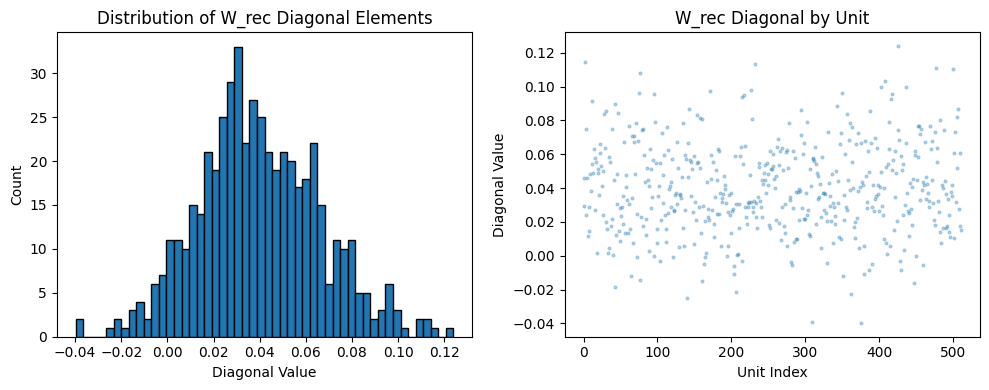

In [29]:
diag_values = model.rnn_step.W_rec.weight.diagonal().detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(diag_values, bins=50, edgecolor="black")
plt.xlabel("Diagonal Value")
plt.ylabel("Count")
plt.title("Distribution of W_rec Diagonal Elements")

plt.subplot(1, 2, 2)
plt.plot(diag_values, "o", alpha=0.3, markersize=2)
plt.xlabel("Unit Index")
plt.ylabel("Diagonal Value")
plt.title("W_rec Diagonal by Unit")
plt.tight_layout()
plt.show()

In [25]:
# Check the activation function
print(f"Activation function: {model.rnn_step.activation}")
print(f"Type: {type(model.rnn_step.activation)}")

# Test it
test_input = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = model.rnn_step.activation(test_input)
print(f"Input: {test_input}")
print(f"Output: {output}")

# ReLU would give: [0, 0, 0, 1, 2]
# Tanh would give: [-0.96, -0.76, 0, 0.76, 0.96]

Activation function: Tanh()
Type: <class 'torch.nn.modules.activation.Tanh'>
Input: tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.9640, -0.7616,  0.0000,  0.7616,  0.9640])
